In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PreProcessing/PyScript')
import readdata

In [2]:
outfile='/Users/ajc/Core/PostProcessing/barrow_watershed/2021/projections/01_12_2021/'

In [3]:
path ='/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_01/'
var_set = ['surface_flux-day.dat']

In [4]:
#Sim = ['CESM_5050_R30_B']
Simulations = [['CESM_5050_R30_B']] #[os.path.join(path,s) for s in Sim]

In [5]:
mol_density = 55300.
to_mm = 1000.
to_day_mm = 86400 * 1000
to_day_year_mm = 86400 * 365 * 1000
to_year_mm = 365 * 1000

In [6]:
def read_file(file):
    d = np.loadtxt(file,usecols=1,skiprows=6)
    t1 = np.loadtxt(file,usecols=0,skiprows=6)
    t = np.array([x/86400./365. for x in t1])
    l = np.minimum(len(d),len(t))
    return d[:l],t[:l]

def read_set(set,var):
    dat = []
    tim = []
    for s in set:
        file = os.path.join(path, s, var)
        d = np.loadtxt(file,usecols=1,skiprows=6)
        t1 = np.loadtxt(file,usecols=0,skiprows=6)
        t = np.array([x/86400./365. for x in t1])
        
        L = len(d)%365
        if L >0:
            d = d[:-L]
            t = t[:len(d)]
            
        dat.append(d)
        tim.append(t)
    dat = np.concatenate(dat)
    tim = np.concatenate(tim)
    print ('Lengths: ',len(dat)%365, len(tim)%365,L)
    
    return dat, tim

In [7]:
forcing_data = h5py.File("/Users/ajc/Core/PreProcessing/ats-intermediate-ngee/data/SNAP/CESM-RCP8.5-2006-2100_dm1985-2015-FM_2006.h5",'r')

In [8]:
d1 = forcing_data['precipitation rain [m s^-1]']
d2 = forcing_data['precipitation snow [m SWE s^-1]']
rain = np.reshape(d1,(-1,365)).mean(axis=1)*86400*365
snow = np.reshape(d2,(-1,365)).mean(axis=1)*86400*365
precip_annual_orig = snow + rain
print (precip_annual_orig[:3])

[0.25900042 0.24096072 0.2829736 ]


In [9]:
key_var = ['surface_star-evaporative_flux']

In [10]:

def getSurfaceData(i,var,hdf_file='ats_vis_surface_star_data.h5',average=True):
    Data = []
    #print ('getSurfaceData: ',var,average)
    for s in Simulations[i]:
        infile = os.path.join(path,s,hdf_file)
        print (infile)
        dx=h5py.File(infile,'r')
        d = np.array(readdata.GetSurfVarFromVis_All(infile,var)[var])
        if (average):
            d = d.mean(axis=1)
        else:
            d = d.sum(axis=1)
        L = len(d)%365
        if L >0:
            d = d[:-L]
        
        Data.append(d)
        
    d = dict()
    d[var] = np.concatenate(Data)
    
    return d

In [11]:
colors = ['r','k','g','m','c','y']
marks = ['.','*', '+', 'o']
marks = ['-','-','-']
Labels = ['basecase','dynamic_sg']

In [12]:
Slabels = ['S1', 'S6']
path_sf =os.path.join(path, Simulations[0][0], 'ats_vis_surface_star_data.h5')
file_surf= h5py.File(path_sf,'r')
cycle = list(file_surf['surface_star-cell_volume.cell.0'].keys())[0]

surface_area = np.sum(list(file_surf['surface_star-cell_volume.cell.0'][cycle]))
print (surface_area)
print (precip_annual_orig[:4])
precip_annual = [p*mol_density*surface_area for p in precip_annual_orig]
print (precip_annual[:4])

112635.47903126487
[0.25900042 0.24096072 0.2829736  0.19995933]
[1613246811.497143, 1500882129.6168385, 1762569550.7478123, 1245495052.0215316]


In [13]:
#spatially averaged over the watershed
def Evaporation():
    Colors = ['k','b','grey','g','r','m']
    time = 2006 + np.linspace(0,94,94,dtype='int')
    d3_sf = []
    sf_change = 0
    for i,sim in enumerate(Simulations):
        var = 'surface_star-evaporative_flux'
        d1 = getSurfaceData(i,var,hdf_file='ats_vis_surface_star_data.h5',average=True)[var]
        d1 = [x*mol_density*surface_area for x in d1]
        
        sf_annual = np.reshape(d1,(-1,365)).mean(axis=1)*86400*365.
        
        d3_sf = [x*to_day_mm for x in d2] 
    return d3_sf, sf_annual

In [14]:
ET_daily, ET_annual = Evaporation()


/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_01/CESM_5050_R30_B/ats_vis_surface_star_data.h5


In [15]:
#spatially averaged over the watershed
def WaterContent(var='surface_star-water_content'):
    Colors = ['k','b','grey','g','r','m']
    time = 2006 + np.linspace(0,94,94,dtype='int')
    sf_annual = []
    var_mdl='surface_star-molar_density_liquid'
    for i,sim in enumerate(Simulations):
        d1 = getSurfaceData(i,var,hdf_file='ats_vis_surface_star_data.h5',average=False)[var]
        
        f1 = np.reshape(d1,(-1,365))#.mean(axis=1)*to_year_mm #mm annual
        for x in f1:
            sf_annual.append(x[-1]-x[0])
        
    return d1, sf_annual


In [16]:
SF_wc_daily, SF_wc_annual = WaterContent()
SS_wc_daily, SS_wc_annual = WaterContent(var='surface_star-column_water_content')

/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_01/CESM_5050_R30_B/ats_vis_surface_star_data.h5
/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_01/CESM_5050_R30_B/ats_vis_surface_star_data.h5


In [17]:
#Snow water content for intermediate scale model is in m^3
def WaterContentSnow(var='surface_star-water_content'):
    Colors = ['k','b','grey','g','r','m']
    time = 2006 + np.linspace(0,94,94,dtype='int')
    d3_sf = []
    sf_annual = []
    for i,sim in enumerate(Simulations):
        d1 = getSurfaceData(i,var,hdf_file='ats_vis_surface_star_data.h5',average=False)[var]
        d2 = [x*mol_density for x in d1]
        d3 = np.reshape(d2,(-1,365))
        for x in d3:
            sf_annual.append(x[-1]-x[0])
        print (sf_annual)
    return d3, sf_annual

In [18]:
Snow_wc_daily, Snow_wc_annual = WaterContentSnow(var='surface_star-water_equivalent')

/Users/ajc/Core/simulations/projections/barrow_watershed/CESM_01/CESM_5050_R30_B/ats_vis_surface_star_data.h5
[165609143.1547538, -162120957.562106, 299244250.0230591, -311776588.6645825, -186619839.1454019, 169135241.06942374, -49820621.64387295, 150320220.5131423, -103022876.46369177]


In [19]:
#Read discharge
def Discharge():
    daily = []
    annual = []
    for i,sim in enumerate(Simulations):
        var = 'surface_flux-day-integrated.dat'
        d1, t1 = read_set(sim,var)
        annual = np.reshape(d1,(-1,365)).mean(axis=1)*365
        print (annual)
    return d1, annual 

In [20]:
Q_daily, Q_annual = Discharge()

Lengths:  0 0 259
[9.17937573e+07 1.59394659e+07 4.50847113e+07 3.24599498e+08
 2.71730990e+08 0.00000000e+00 2.02891711e+07 6.15410455e+05
 2.49411862e+08]


SF: [0.0, 0.0, 61512535.32224113]
SS: [-22410159.532226562, 85182179.69012451, 53440445.05630493]
Snow: [165609143.1547538, -162120957.562106, 299244250.0230591]
Storage: [143198983.62252724, -76938777.8719815, 414197230.4016052]
ET: [1.39555084e+09 1.61202733e+09 1.36021567e+09]
P: [1613246811.497143, 1500882129.6168385, 1762569550.7478123]


Text(0.5, 0, 'Year')

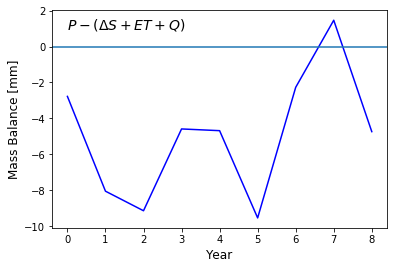

In [21]:

#print (len(SF_wc_annual), len(SS_wc_annual), len(Snow_wc_annual), len(ET_annual), len(Q_annual))
#print (len(SF_wc_annual), len(SS_wc_annual), len(Snow_wc_annual), len(ET_annual), len(Q_annual))
print ('SF:',SF_wc_annual[:3])
print ('SS:',SS_wc_annual[:3])
print ('Snow:',Snow_wc_annual[:3])
storage= [x+y+z for x,y,z in zip(SF_wc_annual,SS_wc_annual,Snow_wc_annual)]

ET = ET_annual 
Q = Q_annual
print ('Storage:',storage[:3])
#print (Q[:3])
print ('ET:',ET[:3])
print ('P:', precip_annual[:3])
#print (Q)
f = []
for i in range(len(ET)):
    x = (precip_annual[i] - (storage[i] + ET[i] + Q[i]))/(mol_density*surface_area)*1000
    f.append(x)
    #print (f, precip_annual[i], storage[i], ET[i], Q[i])
    #break
plt.plot(f,'b')
plt.axhline(y=0)
plt.text(0,1,r'$P - (\Delta S + ET + Q)$', fontsize=14)
plt.ylabel('Mass Balance [mm]',fontsize=12)
plt.xlabel('Year',fontsize=12)